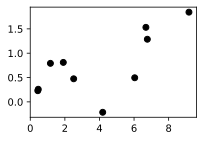

In [36]:
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = "svg"


def true_function(X):
    return (np.sin(X) + (X / 7) ** 2)

N = 10
rng = np.random.RandomState(41)
X = rng.rand(N) * 10
y = true_function(X) + rng.randn(N) * 0.2

plt.figure(figsize=(3, 2))
plt.plot(X, y, "ok")

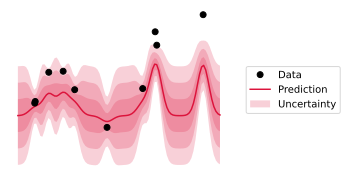

In [37]:
from mini_gpr.models import GPR
from mini_gpr.kernels import RBF
from mini_gpr.viz import show_model_predictions


model = GPR(kernel=RBF(sigma=0.3, scale=0.3), noise=0.3)
model.fit(X, y)

plt.figure(figsize=(4, 3))
show_model_predictions(model, X, y)

In [38]:
model.log_likelihood

np.float64(-12.907023974383769)

In [39]:
from mini_gpr.opt import optimise_model, maximise_log_likelihood
from mini_gpr.models import GPR
from mini_gpr.kernels import RBF, Constant

best_model = optimise_model(
    GPR(kernel=RBF(), noise=0.3),
    maximise_log_likelihood,
    X,
    y,
)
best_model

GPR(kernel=RBF(scale=0.9205263516184004, sigma=[2.28470369]), noise=0.3)

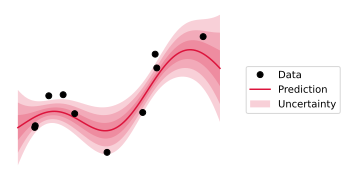

In [40]:
plt.figure(figsize=(4, 3))
show_model_predictions(best_model, X, y)

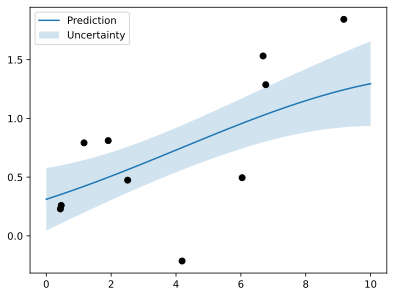

In [41]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

model = GaussianProcessRegressor(kernel=RBF(2.0) * ConstantKernel(1.8), alpha=0.3)
model.fit(X.reshape(-1, 1), y)

xx = np.linspace(0, 10, 100)
yy, sigma_yy = model.predict(xx.reshape(-1, 1), return_std=True)
plt.plot(xx, yy, label="Prediction")
plt.fill_between(xx, yy - sigma_yy, yy + sigma_yy, alpha=0.2, label="Uncertainty")
plt.plot(X, y, "ok")
plt.legend()
plt.show()

(np.float64(-0.5),
 np.float64(10.5),
 np.float64(-1.213354197793817),
 np.float64(2.273373603772442))

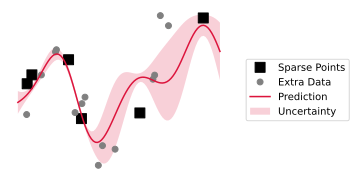

In [6]:
from mini_gpr.models import SoR

model = SoR(kernel=RBF(sigma=1.0), noise=3e-1, n_sparse=6)
model.fit(X, y)

M = model.M
# find the index in X for each point in M
# M_idxs = np.array([np.where(X == m)[0][0] for m in M])

sparse_idxs = np.isin(X, M)
plt.figure(figsize=(4, 3))
plt.plot(
    X[sparse_idxs],
    y[sparse_idxs],
    "s",
    color="black",
    markersize=10,
    label="Sparse Points",
)
plt.plot(
    X[~sparse_idxs],
    y[~sparse_idxs],
    "o",
    color="gray",
    label="Extra Data",
)

xx = np.linspace(0, 10, 100)
yy, sigma_yy = model.predict(xx), model.uncertainty(xx)

plt.plot(xx, yy, "-", color="crimson", label="Prediction")
plt.fill_between(
    xx,
    yy - sigma_yy,
    yy + sigma_yy,
    alpha=0.2,
    color="crimson",
    label="Uncertainty",
    lw=0,
)

plt.legend(bbox_to_anchor=(1.05, 0.5), loc="center left")
plt.axis("off")


In [7]:
from mini_gpr.models import FITC
from mini_gpr.kernels import RBF
from mini_gpr.selection import GridSelector

model = FITC(kernel=RBF(sigma=1.0), noise=3e-1, n_sparse=7, strategy=GridSelector)

model.fit(X, y)
M = model.M
plt.figure(figsize=(4, 3))
plt.plot(
    X,
    y,
    "o",
    color="grey",
    label="Data",
)
plt.plot(
    model.M,
    [1.05] * len(model.M),
    "vk",
    transform=plt.gca().get_xaxis_transform(),
    clip_on=False,
    label="Inducing Points",
)
xx = np.linspace(0, 10, 100)
yy, sigma_yy = model.predict(xx), model.uncertainty(xx)

plt.plot(xx, yy, "-", color="crimson", label="Prediction")
plt.fill_between(
    xx,
    yy - sigma_yy,
    yy + sigma_yy,
    alpha=0.2,
    color="crimson",
    label="Uncertainty",
    lw=0,
)

plt.legend(bbox_to_anchor=(1.05, 0.5), loc="center left")
plt.axis("off")

ImportError: cannot import name 'FITC' from 'mini_gpr.models' (/Users/john/projects/mini-gpr/src/mini_gpr/models.py)

In [ ]:
# create a pipeline model that first normalises the data and then fits a gpr model
from sklearn.linear_model import LinearRegression
from mini_gpr.utils import ModelStack

lr = LinearRegression()
gpr = GPR(kernel=RBF(sigma=0.5), noise=1e-1)

model = ModelStack(lr, gpr)
model.fit(X[:, None], y)


xx = np.linspace(0, 10, 100)
yy = model.predict(xx[:, None])
yy_std = gpr.uncertainty(xx)

plt.plot(X, y, "ok")
plt.plot(xx, yy, "-r")
plt.fill_between(xx, yy - yy_std, yy + yy_std, alpha=0.2);

In [ ]:
lr = LinearRegression()
gpr = GPR(kernel=RBF(sigma=0.5), noise=1e-1)

model = ModelStack(lr, gpr)
model.fit(X[:, None], y)


xx = np.linspace(0, 10, 100)
yy0 = model[0].predict(xx[:, None])
yy1 = model[1].predict(xx[:, None])

plt.plot(X, y, "ok")
plt.plot(xx, yy0, "-r")
plt.plot(xx, yy1 + yy0, "-b")

In [ ]:
import numpy as np

def get_grid(xlim, ylim, N=100) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    x = np.linspace(xlim[0], xlim[1], N)
    y = np.linspace(ylim[0], ylim[1], N)
    mesh_x, mesh_y = np.meshgrid(x, y)
    return x, y, np.stack([mesh_x.ravel(), mesh_y.ravel()], axis=1)

In [ ]:
from jaxtyping import Float
from mini_gpr import auto_fit_gpr


def himmelblau(X: Float[np.ndarray, "A 2"]):
    x, y = X.T
    return np.log((x**2 + y - 11) ** 2 + (x + y**2 - 7) ** 2)


X_train = np.random.RandomState(42).rand(200, 2) * 10 - 5
y_train = himmelblau(X_train)

model = auto_fit_gpr(X_train, y_train, lengthscale=2, noise=1e-1)

# test on grid of points
xx, yy, X_test = get_grid((-5, 5), (-5, 5))
y_test = model.predict(X_test)

plt.contourf(xx, yy, y_test.reshape(100, 100), cmap="viridis")
plt.scatter(*X_train.T, c="w", edgecolors="k", clip_on=False)
plt.gca().set_aspect("equal")
plt.axis("off")
plt.colorbar()